# Titanic Survival Prediction (First attempt at Kaggle Competitions)

## Exploratory Data Analysis

In [12]:
# import required libraries

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [2]:
# list of files 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
display("Train data", train_df.head(5))
display("Test data", test_df.head(5))

'Train data'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


'Test data'

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
#make copies of datasets
train = train_df.copy()
test = test_df.copy()
#drop unnecessary columns
train.drop(columns = [ "PassengerId","Cabin", "Name", "Ticket", "Cabin"], inplace = True)
test.drop(columns = ["PassengerId","Cabin", "Name", "Ticket", "Cabin"], inplace = True)

In [5]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

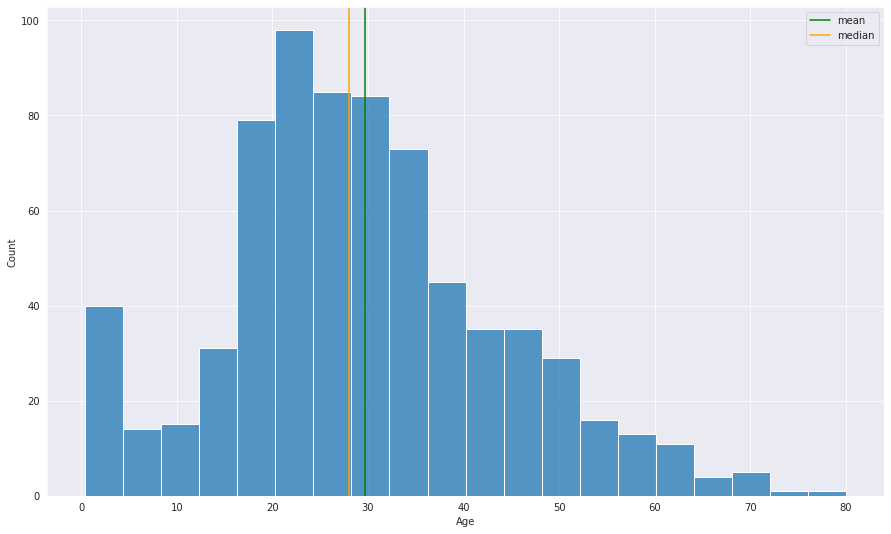

In [6]:
## Age
sns.set_style("darkgrid")
plt.figure(figsize = (15, 9))
sns.histplot(train_df["Age"])
plt.axvline(x = train["Age"].mean(), label = "mean", c = 'green')
plt.axvline(x = train["Age"].median(), label = "median", c = 'orange')
plt.legend()
plt.show()

Both the median and mean age are close together at around 30 years old. Just because the age distribution is close to normal, I will impute the missing age values for mean. 

In [7]:
train['Age'].fillna(train['Age'].mean(), inplace = True)

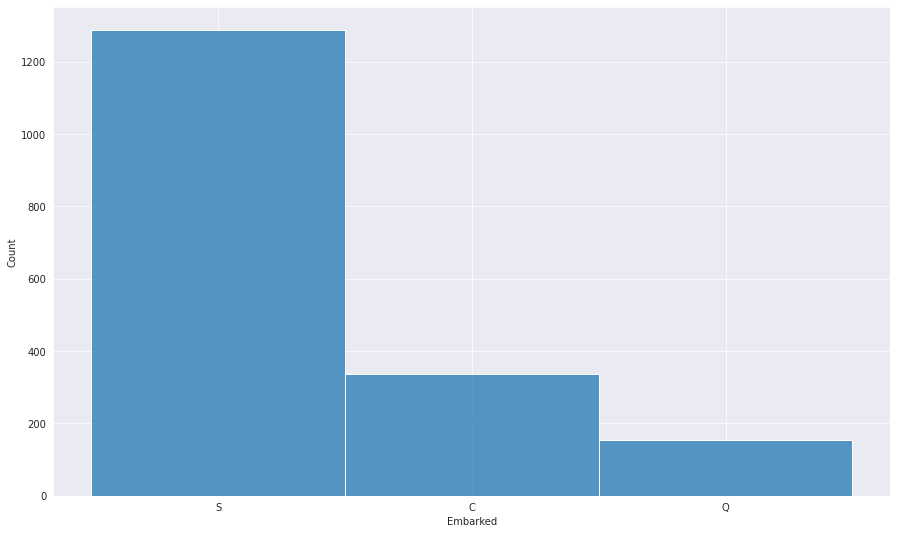

In [13]:
plt.figure(figsize = (15,9))
sns.histplot(combined['Embarked'])
plt.show()

The majority of passengers embarked from the Southampton port, I think it would be safe to assume that two missing passenger values are also Southamptom.

In [8]:
train['Embarked'].fillna("S", inplace = True)

In [9]:
## Reavaluate missing values
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

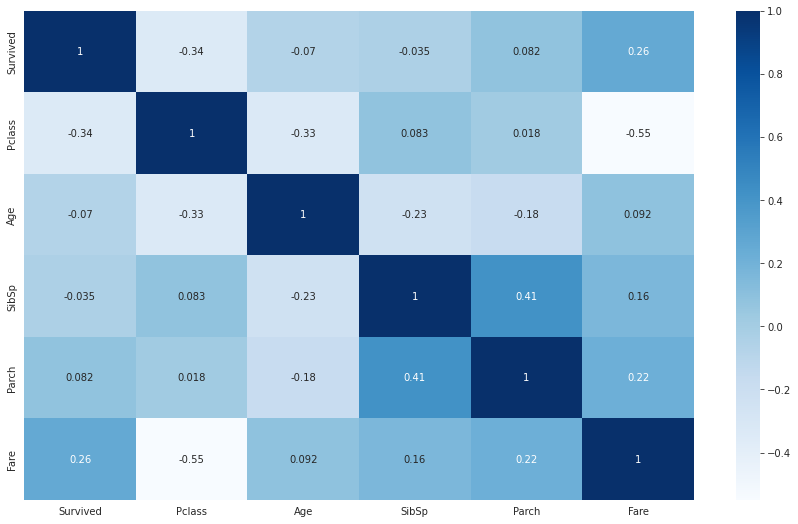

In [10]:
## generate a correlation matrix between features
plt.figure(figsize = (15,9))
sns.heatmap(train.corr(), cmap = 'Blues', annot = True)
plt.show()

Whether a passenger survived seems to have a slight **positive linear correlation** with the amount of *Fare* they paid and **negative linear correlation** with passenger class (*PClass*), but other than that, there is no strong linear correlation with other features. 

There seem to be some collinearity between **PClass and Fare** (passenger class and fare), **Parch and SibSp** (number of parents and siblings on the boat). We might consider merging these columns, if we decide fit a linear model. 

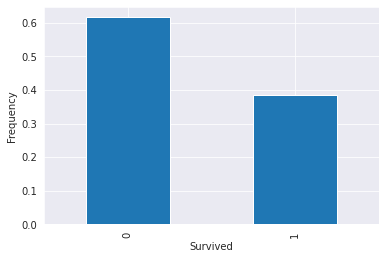

In [11]:
## investigating target feature and classes
train['Survived'].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Survived")
plt.ylabel("Frequency")
plt.show()

## One Hot Encoding

In [20]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
train['Embarked'] = le.fit_transform(train['Embarked'])

test['Sex'] = le.fit_transform(test['Sex'])
test['Embarked'] = le.fit_transform(test['Embarked'])

In [22]:
display(train.head())
display(test.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


In [27]:
X_train = train.drop(columns = ['Survived'], axis = 1)
y_train = train['Survived']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Split data set into train and test sets

## Modeling using all features as they are

### Logistic Regression

In [28]:
logit = LogisticRegression()
kfolds = StratifiedKFold(n_splits = 5)  # use StratifiedKFold since we have class imbalance
logit_result = cross_val_score(logit, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"Model accuracy: {logit_result.mean()}")

Model accuracy: 0.7845207457158998


### Random Forest

In [29]:
rf = RandomForestClassifier(random_state = 111)
rf_result = cross_val_score(rf, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"Model accuracy: {rf_result.mean()}")

Model accuracy: 0.8159625886636119


### K-Nearest Neighbors

In [30]:
## use different k values to find an optimal value for the highest accuracy

k_range = range(3, 10, 2)
val_acc = dict()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_results = cross_val_score(knn, X_train_scaled, y_train, cv = 5, scoring = 'accuracy')
    val_acc[k] = knn_results.mean() 
val_acc


{3: 0.7890214048082355,
 5: 0.8013684012303056,
 7: 0.799114933149206,
 9: 0.8080723118448307}

### XGBoost

In [31]:
xgboost_classifier = XGBClassifier()
xgboost_res = cross_val_score(xgboost_classifier, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"XGBoost accuracy: {xgboost_res.mean()}")

XGBoost accuracy: 0.8125980792166217


### SVM

In [32]:
svm_classifier = SVC()
svm_result = cross_val_score(svm_classifier, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
# print(f"SVM accuracy: {svm_result.mean()})
print(f"SVM accuracy: {svm_result.mean()}")

SVM accuracy: 0.827154604230745


### Can I increase base accuracy by engineering some new features?

<AxesSubplot:ylabel='Frequency'>

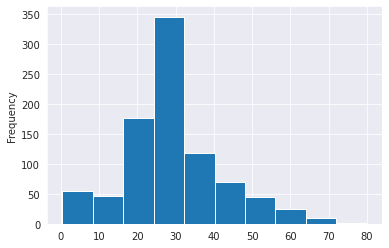

In [34]:
# start with age
X_train.Age.plot(kind = 'hist')

### Fine-tuning Random Forest, KNN, and XGBoost

In [60]:
estimators = [
    ("normalise", StandardScaler()), 
    ("model", XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [
    {"model": [XGBClassifier()],
    "normalise": [StandardScaler(), None],
    "model__gamma": [0.001, 0.01, 0.1, 1, 10],
    "model__reg_lambda":[0, 1, 10], 
    "model__max_depth": [3, 4, 5, 7],
    "model__colsample_bytree": [0.5], 
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    },
    
    {"model": [RandomForestClassifier()], 
     "normalise": [StandardScaler(), None],
     "model__n_estimators": [10, 30, 50, 100],
     "model__max_depth": [1, 2, 3, 4] 
    },
    
    {"model": [KNeighborsClassifier()],
     "normalise": [StandardScaler(), None],
     "model__n_neighbors": [3, 5, 7, 9, 11], 
     "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]     
    }
]

grid = GridSearchCV(pipe, param_grid, cv=kfolds, n_jobs = -1)
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.fit(X_train, y_train)
print(f"Best score: {fittedgrid.best_score_} using {fittedgrid.best_params_}")

Best score: 0.8941526104417671 using {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.01,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=0, ...), 'model__colsample_bytree': 0.5, 'model__gamma': 0.01, 'model__learning_rate': 0.3, 'model__max_depth': 7, 'model__reg_lambda': 0, 'normalise': StandardScaler()}


In [64]:
# y_pred = fittedgrid.predict(X_test)
# submission = pd.read_csv('../input/titanic/gender_submission.csv')
